# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [77]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

from IPython.display import Image
from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 200000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (200000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [0]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [5]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [6]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [7]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [8]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(160178, 10)

In [9]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

80.089

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [10]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [11]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [12]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(160176, 10)


1    134799
0     25377
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [13]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

I remembered this book from my childhood and got it for my kids.  It's just as good as I remembered and my kids love it too.  My older daughter now reads it to her sister.  Good rhymes and nice pictures.
The qualitys not as good as the lamb and rice but it didn't seem to bother his stomach, you get 10 more pounds and it is cheaper wich is a plus for me. You can always ad your own rice and veggies. Its fresher that way and better for him in my opinion. Plus if you you can get it deliverd to your house for free its even better.  Gotta love pitbulls
This is the Japanese version of breadcrumb (pan=bread, a Portuguese loan-word, and&quot;ko-&quot;  is &quot;child of&quot; or of &quot;derived from&quot;.) Panko are used for katsudon, tonkatsu or cutlets served on rice or in soups. The cutlets, pounded chicken or pork, are coated with these light and crispy crumbs and fried. They are not gritty and dense like regular crumbs. They are very nice on deep fried shrimps and decorative for a more g

In [14]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

I remembered this book from my childhood and got it for my kids.  It's just as good as I remembered and my kids love it too.  My older daughter now reads it to her sister.  Good rhymes and nice pictures.


In [15]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

I remembered this book from my childhood and got it for my kids.  It's just as good as I remembered and my kids love it too.  My older daughter now reads it to her sister.  Good rhymes and nice pictures.
The qualitys not as good as the lamb and rice but it didn't seem to bother his stomach, you get 10 more pounds and it is cheaper wich is a plus for me. You can always ad your own rice and veggies. Its fresher that way and better for him in my opinion. Plus if you you can get it deliverd to your house for free its even better.  Gotta love pitbulls
This is the Japanese version of breadcrumb (pan=bread, a Portuguese loan-word, and"ko-"  is "child of" or of "derived from".) Panko are used for katsudon, tonkatsu or cutlets served on rice or in soups. The cutlets, pounded chicken or pork, are coated with these light and crispy crumbs and fried. They are not gritty and dense like regular crumbs. They are very nice on deep fried shrimps and decorative for a more gourmet touch.
What can I say..

In [16]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [17]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

This is the Japanese version of breadcrumb (pan=bread, a Portuguese loan-word, and&quot;ko-&quot;  is &quot;child of&quot; or of &quot;derived from&quot;.) Panko are used for katsudon, tonkatsu or cutlets served on rice or in soups. The cutlets, pounded chicken or pork, are coated with these light and crispy crumbs and fried. They are not gritty and dense like regular crumbs. They are very nice on deep fried shrimps and decorative for a more gourmet touch.


In [18]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

I remembered this book from my childhood and got it for my kids.  It's just as good as I remembered and my kids love it too.  My older daughter now reads it to her sister.  Good rhymes and nice pictures.


In [19]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

This is the Japanese version of breadcrumb pan bread a Portuguese loan word and quot ko quot is quot child of quot or of quot derived from quot Panko are used for katsudon tonkatsu or cutlets served on rice or in soups The cutlets pounded chicken or pork are coated with these light and crispy crumbs and fried They are not gritty and dense like regular crumbs They are very nice on deep fried shrimps and decorative for a more gourmet touch 


In [20]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [21]:
# Combining all the above stundents 
from tqdm import tqdm
prepr_rev = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    prepr_rev.append(sentance.strip())
    
    

100%|██████████| 160176/160176 [01:14<00:00, 2139.28it/s]


In [22]:
prepr_rev[1500]

'japanese version breadcrumb pan bread portuguese loan word ko child derived panko used katsudon tonkatsu cutlets served rice soups cutlets pounded chicken pork coated light crispy crumbs fried not gritty dense like regular crumbs nice deep fried shrimps decorative gourmet touch'

In [23]:
print(len(prepr_rev))
final.shape

160176


(160176, 10)

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [24]:
## Similartly you can do preprocessing for review summary also.
preprocessed_summary = []
# tqdm is for printing the status bar
for summary in tqdm(final['Summary'].values):
    summary = re.sub(r"http\S+", "", summary) # remove urls from text python: https://stackoverflow.com/a/40823105/4084039 
    summary = BeautifulSoup(summary, 'lxml').get_text() # https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
    summary = decontracted(summary)
    summary = re.sub("\S*\d\S*", "", summary).strip() #remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
    summary = re.sub('[^A-Za-z]+', ' ', summary) #remove spacial character: https://stackoverflow.com/a/5843547/4084039
    # https://gist.github.com/sebleier/554280
    summary = ' '.join(e.lower() for e in summary.split() if e.lower() not in stopwords)
    preprocessed_summary.append(summary.strip())


 58%|█████▊    | 92533/160176 [00:27<00:19, 3466.71it/s]/Volumes/Saida/Applications/Anaconda/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:273: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
100%|██████████| 160176/160176 [00:47<00:00, 3382.00it/s]


In [25]:
prepr_rev = [i + ' ' + j for i, j in zip(prepr_rev,preprocessed_summary)] 
print(prepr_rev[1500])

japanese version breadcrumb pan bread portuguese loan word ko child derived panko used katsudon tonkatsu cutlets served rice soups cutlets pounded chicken pork coated light crispy crumbs fried not gritty dense like regular crumbs nice deep fried shrimps decorative gourmet touch essential tonkatsu etc


In [26]:
final ['CleanText']= prepr_rev
final.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanText
138695,150513,0006641040,ASH0DZQQF6AIZ,tessarat,0,0,1,1325721600,A classic,I remembered this book from my childhood and g...,remembered book childhood got kids good rememb...
138707,150525,0006641040,A2QID6VCFTY51R,Rick,1,2,1,1025481600,"In December it will be, my snowman's anniversa...","My daughter loves all the ""Really Rosie"" books...",daughter loves really rosie books introduced r...
138708,150526,0006641040,A3E9QZFE9KXH8J,R. Mitchell,11,18,0,1129507200,awesome book poor size,This is one of the best children's books ever ...,one best children books ever written mini vers...
138686,150504,0006641040,AQEYF1AXARWJZ,"Les Sinclair ""book maven""",1,1,1,1212278400,Chicken Soup with Rice,A very entertaining rhyming story--cleaver and...,entertaining rhyming story cleaver catchy illu...
138685,150503,0006641040,A3R5XMPFU8YZ4D,"Her Royal Motherliness ""Nana""",1,1,1,1233964800,so fun to read,This is my grand daughter's and my favorite bo...,grand daughter favorite book read loves rhythm...


# [4] Featurization

## [4.1] BAG OF WORDS

In [27]:
##Sorting data for Time Based Splitting
time_sorted_data = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')


final = time_sorted_data.take(np.random.permutation(len(final))[:100000])
print(final.shape)
final.head()

(100000, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanText
116456,126291,B000F8GWRM,A19QUHVT4ZQOFE,Cdutton626,0,0,0,1339718400,DO NOT EAT WILL CAUSE YOU THE WORST GAS PAIN EVER,I love Twizlers so I thought I would try the s...,love twizlers thought would try sugar free ver...
61113,66407,B0039555VM,A2ZRQGSEYBE67J,Ronald I. Brigham,0,0,1,1293753600,My favorite coffee!,I really like this coffee and have been buying...,really like coffee buying several years howeve...
171281,185831,B000S6CCJ8,A1W1FJS9PMCN13,Jane Benedict,2,2,1,1254873600,Wisotsky Tea Chest,Great for personal use and for gifts. We've bo...,great personal use gifts bought many people al...
12209,13321,B004286RC6,A2NRNO4MDXRR3N,Tom Farrell,0,0,1,1333843200,Best Chocolate,"See's, in my opinion, makes absolutely the bes...",see opinion makes absolutely best chocolate un...
154359,167368,B007PE7ANY,A2DOO9CCQFMXTB,Gayle,0,2,0,1346803200,Salty,"I tried this product, I didn't like it it was ...",tried product not like salty anyone high blood...


In [28]:
X = np.array(prepr_rev)
y = np.array(final['Score'])

In [30]:
from sklearn.model_selection import train_test_split
#splitting data into Train, C.V and Test
X_train, X_test, y_train, y_test = train_test_split(final ['CleanText'], final['Score'], test_size=0.33) 
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33)
print("Train:",X_train.shape,y_train.shape)
print("CV:",X_cv.shape,y_cv.shape)
print("Test:",X_test.shape,y_test.shape)

Train: (44890,) (44890,)
CV: (22110,) (22110,)
Test: (33000,) (33000,)


In [31]:
#BoW
vectorizer = CountVectorizer(min_df=10, max_features=500) 
vectorizer.fit(X_train)
#vectorizer.fit(X_train) # fit has to happen only on train data
# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer.transform(X_train)
X_cv_bow = vectorizer.transform(X_cv)
X_test_bow = vectorizer.transform(X_test) 
print("After vectorizations")
print(X_train_bow.shape, y_train.shape) 
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape) 

After vectorizations
(44890, 500) (44890,)
(22110, 500) (22110,)
(33000, 500) (33000,)


## [4.2] Bi-Grams and n-Grams.

In [34]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice


vectorizer = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000) 
vectorizer.fit(X_train)
#vectorizer.fit(X_train) # fit has to happen only on train data
# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer.transform(X_train)
X_cv_bow = vectorizer.transform(X_cv)
X_test_bow = vectorizer.transform(X_test) 
print("After vectorizations")
print(X_train_bow.shape, y_train.shape) 
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape) 
 
print("the number of unique words including both unigrams and bigrams ", X_train_bow.get_shape()[1])

After vectorizations
(44890, 5000) (44890,)
(22110, 5000) (22110,)
(33000, 5000) (33000,)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [35]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=500)
tf_idf_vect.fit(X_train)
# we use the fitted CountVectorizer to convert the text to vector
X_train_tfidf = tf_idf_vect.transform(X_train)
X_cv_tfidf = tf_idf_vect.transform(X_cv)
X_test_tfidf = tf_idf_vect.transform(X_test) 
print("After vectorizations")
print(X_train_tfidf.shape, y_train.shape) 
print(X_cv_tfidf.shape, y_cv.shape)
print(X_test_tfidf.shape, y_test.shape) 
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)


After vectorizations
(44890, 500) (44890,)
(22110, 500) (22110,)
(33000, 500) (33000,)
some sample features(unique words in the corpus) ['able', 'absolutely', 'actually', 'add', 'added', 'aftertaste', 'ago', 'almost', 'already', 'also']


## [4.4] Word2Vec

In [36]:
# Train your own Word2Vec model using your own text corpus
sent_of_train=[]
for sent in X_train:
    sent_of_train.append(sent.split())

# List of sentence in X_test text
sent_of_test=[]
for sent in X_test:
    sent_of_test.append(sent.split())   
    
# Train your own Word2Vec model using your own train text corpus 
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(sent_of_train,min_count=5,size=50, workers=4)
print(w2v_model.wv.most_similar('great'))
print('='*50)
print(w2v_model.wv.most_similar('worst'))
    
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))

[('awesome', 0.8556177020072937), ('fantastic', 0.8334372043609619), ('terrific', 0.8264545202255249), ('good', 0.8171184062957764), ('excellent', 0.8021589517593384), ('wonderful', 0.7396981120109558), ('nice', 0.696800947189331), ('amazing', 0.6952731609344482), ('perfect', 0.6881289482116699), ('fabulous', 0.6758981943130493)]
[('greatest', 0.7232632637023926), ('best', 0.7159654498100281), ('nastiest', 0.6743019223213196), ('disgusting', 0.6637505292892456), ('tastiest', 0.6406117677688599), ('horrible', 0.6134984493255615), ('awful', 0.5990911722183228), ('weakest', 0.5862331986427307), ('smoothest', 0.5806785821914673), ('terrible', 0.5738176107406616)]
number of words that occured minimum 5 times  13343


In [37]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  13343
sample words  ['thick', 'utterly', 'delicious', 'balsamic', 'vinegar', 'no', 'caramel', 'coloring', 'artificial', 'additives', 'love', 'find', 'positively', 'addictive', 'far', 'best', 'tasted', 'tried', 'many', 'different', 'brands', 'indeed', 'worth', 'every', 'penny', 'another', 'reviewer', 'noted', 'however', 'seen', 'significantly', 'better', 'prices', 'least', 'two', 'brick', 'mortar', 'stores', 'ever', 'loved', 'original', 'walgreens', 'stopped', 'carrying', 'ordered', 'amazon', 'not', 'fault', 'flavor', 'changed']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [38]:
i=0
sent_of_test_cv=[]
for sentance in X_cv:
    sent_of_test_cv.append(sentance.split())

In [39]:
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(sent_of_test_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
sent_vectors_cv = np.array(sent_vectors_cv)
print(sent_vectors_cv.shape)
print(sent_vectors_cv[0])

100%|██████████| 22110/22110 [01:12<00:00, 303.95it/s]

(22110, 50)
[ 2.10879025e-01 -3.48979588e-01 -2.82775587e-01  5.26032030e-01
  5.53550757e-03  2.10376255e-02  4.25016807e-01 -5.90636294e-01
 -2.70678211e-01  6.30688488e-02  7.79606439e-01  3.37669363e-01
 -5.56653980e-01  2.48347844e-04  3.28603715e-01  1.41075848e-01
  3.94519731e-01  4.10266740e-01 -8.83218416e-01  6.48740852e-02
 -8.42590893e-02  4.89774836e-01 -3.94979228e-01  2.32904077e-02
 -2.42288573e-01  1.95402906e-01  7.55785605e-01  6.08583945e-01
  4.63347926e-01  2.94547666e-01  7.61879325e-01 -1.81995569e-01
  6.91946273e-01  2.26891597e-01  6.94460502e-01 -5.22611486e-02
  7.77595306e-01  3.12045039e-02  4.23307268e-01  2.34798140e-01
  3.53932600e-01  5.94060239e-01 -3.31579724e-01 -4.59658874e-01
  1.62416048e-01  7.06878490e-01  6.94606354e-01 -3.08406014e-01
  4.56698843e-01 -7.25057525e-02]


In [40]:
# average Word2Vec
# compute average word2vec for each review.
# compute average word2vec for X_test .
test_vectors = []; 
for sent in tqdm(sent_of_test):
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_vectors.append(sent_vec)  
    
test_vectors = np.array(test_vectors)

print(test_vectors.shape)
print(test_vectors[0])  




100%|██████████| 33000/33000 [01:55<00:00, 285.09it/s]

(33000, 50)
[-0.04484278 -0.98094821  0.06490975  0.77845469  0.06160066 -0.38127362
  0.12176091 -0.48559902  0.52513363 -0.54016219  0.1140505  -0.01575537
  0.16055723 -0.10981051 -0.24351136  0.26646428  0.15815589  0.07710142
  0.01434893 -0.36858722 -0.42938664 -0.11335435 -0.55403221  0.7508934
 -0.27931624 -0.32391615  0.21598508  0.05881603  0.5975235  -0.35665337
  0.41293948 -0.47716167  0.28751567 -0.0017753   1.29433724  0.01361005
  0.07377485 -0.17576912  0.48629449  0.24419177 -0.21880108  0.31494414
  0.56726783 -0.56366112  0.08059364  0.61108769  0.91993372 -0.61532114
  0.45034025 -0.11152897]


In [41]:
# compute average word2vec for X_train .
train_vectors = []; 
for sent in tqdm(sent_of_train):
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_vectors.append(sent_vec)
    
train_vectors = np.array(train_vectors)

print(train_vectors.shape)
print(train_vectors[0])

100%|██████████| 44890/44890 [02:09<00:00, 347.64it/s]


(44890, 50)
[ 0.20589348 -0.46647361  0.30686487  0.67855221 -0.2245382  -0.14743991
  0.16249183 -0.56041429  0.0903703   0.19374888  0.41164201 -0.13900378
 -0.20276569  0.78398465 -0.07428925  0.74533296  0.20773133  0.29324919
 -0.22018799 -0.40283698 -0.50687322  0.86521718 -0.16656635  0.12893605
 -0.47053649 -0.14061254  0.27277417  0.00657488 -0.35115422  0.42768579
  0.56756557 -0.57841713 -0.24381239 -0.3229239   1.32751345  0.76809751
 -0.35866272  0.09910044  0.38541745 -0.03158472  0.16374991  0.6143065
  0.03423175 -0.24805431 -0.54617593  0.01464439  0.45464489  0.35100201
  0.13069364 -0.2408401 ]


#### [4.4.1.2] TFIDF weighted W2v

In [42]:
tf_idf_vect = TfidfVectorizer()

# final_tf_idf1 is the sparse matrix with row= sentence, col=word and cell_val = tfidf
final_tf_idf1 = tf_idf_vect.fit_transform(X_train)
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))

# tfidf words/col-names
tfidf_feat = tf_idf_vect.get_feature_names()

# compute TFIDF Weighted Word2Vec for X_test .
tfidf_test_vectors = []; 
row=0;
for sent in tqdm(sent_of_test): 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_test_vectors.append(sent_vec)
    
tfidf_test_vectors = np.array(tfidf_test_vectors)
print(tfidf_test_vectors.shape)
print(tfidf_test_vectors[0])

100%|██████████| 33000/33000 [23:11<00:00, 23.71it/s]  

(33000, 50)
[-0.05867975 -0.81840016  0.01550789  0.76012586 -0.07593843 -0.25108136
  0.17660245 -0.29453132  0.4457865  -0.45814356  0.00955802  0.0207721
  0.16425236  0.05244858 -0.200853    0.15241338  0.21510971  0.10148712
  0.05810314 -0.30514034 -0.38030058 -0.07415261 -0.56575887  0.69470838
 -0.27209041 -0.1847674   0.27319222  0.10213101  0.53012813 -0.33384253
  0.38188978 -0.32749265  0.22372857 -0.13716998  1.12177612  0.10011898
  0.12335294 -0.11740182  0.38993361  0.23355767 -0.14113065  0.28826309
  0.48279012 -0.58987134  0.03591074  0.4788944   0.86686662 -0.58208808
  0.30676786 -0.22806437]


In [43]:
# TF-IDF weighted Word2Vec
# compute TFIDF Weighted Word2Vec for X_train .
tfidf_train_vectors = []; 
row=0;
for sent in tqdm(sent_of_train): 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_train_vectors.append(sent_vec)

tfidf_train_vectors = np.array(tfidf_train_vectors)
print(tfidf_train_vectors.shape)
print(tfidf_train_vectors[0])

100%|██████████| 44890/44890 [32:24<00:00, 23.08it/s]  

(44890, 50)
[ 0.23749914 -0.33554841  0.59981253  0.56687557 -0.41496096 -0.31974582
  0.21053894 -0.55191055 -0.00614808  0.06785204  0.2023     -0.46574261
  0.07462821  1.56342778  0.05565031  0.90016656  0.01315081  0.46672271
  0.11828226 -0.40188229 -0.50410301  0.90837816 -0.19803636  0.14962699
  0.12799858 -0.37108493  0.49690321 -0.19898207 -0.28724165  0.22887403
  0.27847209 -0.4231636  -0.38710967 -0.40896379  0.88220628  1.09786892
 -0.24679644  0.05527545  0.43963774 -0.19567637  0.42734269  0.88291983
 -0.03657182 -0.54552855 -0.61266246 -0.02088902  0.56070897  0.50443178
 -0.10266092 -0.37483865]


# [5] Assignment 8: Decision Trees

<ol>
    <li><strong>Apply Decision Trees on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (best `depth` in range [1, 5, 10, 50, 100, 500, 100], and the best `min_samples_split` in range [5, 10, 100, 500])</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Graphviz</strong>
        <ul>
    <li>Visualize your decision tree with Graphviz. It helps you to understand how a decision is being made, given a new vector.</li>
    <li>Since feature names are not obtained from word2vec related models, visualize only BOW & TFIDF decision trees using Graphviz</li>
    <li>Make sure to print the words in each node of the decision tree instead of printing its index.</li>
    <li>Just for visualization purpose, limit max_depth to 2 or 3 and either embed the generated images of graphviz in your notebook, or directly upload them as .png files.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 20 important features from both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using `feature_importances_` method of <a href='https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html'>Decision Tree Classifier</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Decision Trees

## [5.1] Applying Decision Trees on BOW,<font color='red'> SET 1</font>

In [123]:
# Please write all the code with proper documentation
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import roc_auc_score, auc
from sklearn.model_selection import GridSearchCV

def all_dt(X_train,y_train,X_cv):
    depth = [1, 5, 10, 50, 100, 500, 100]
    min_sample_split = [5, 10, 100, 500]
    hyper_param = {'max_depth':depth, 'min_samples_split':min_sample_split}
        
    
    clf = DecisionTreeClassifier(class_weight='balanced')
    gsv = GridSearchCV(clf,hyper_param,scoring='roc_auc')
    gsv.fit(X_train_bow,y_train)
    opt_depth, opt_split  = gsv.best_params_.get('max_depth'), gsv.best_params_.get('min_samples_split')
    
    
    train_auc= gsv.cv_results_['mean_train_score']
    train_auc_std= gsv.cv_results_['std_train_score']
    cv_auc = gsv.cv_results_['mean_test_score'] 
    cv_auc_std= gsv.cv_results_['std_test_score']
    
    
    x2 = np.arange(len(depth))
    plt.plot(x2,train_auc[::4],'r', label = 'Train Data of(5)')
    plt.plot(x2,cv_auc[::4],'r--', label = 'CV Data of(5)')
    
    plt.plot(x2,train_auc[1::4],'b', label = 'Train Data of(10)')
    plt.plot(x2,cv_auc[1::4],'b--', label = 'CV Data of(10)')

    plt.plot(x2,train_auc[2::4],'g', label = 'Train Data of(100)')
    plt.plot(x2,cv_auc[2::4],'g--', label = 'CV Data of(100)')

    plt.plot(x2,train_auc[3::4],'y', label = 'Train Data of(500)')
    plt.plot(x2,cv_auc[3::4],'y--', label = 'CV Dataof (500)')
    
    
    plt.xticks(x2, depth)
    plt.ylim(0,1)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.grid(True)
    plt.title("Train and CV Data")
    plt.xlabel("Depth")
    plt.ylabel("AUC")
    plt.show()
    
    
    df_heatmap = pd. DataFrame(train_auc. reshape(7, 4), index=depth, columns=min_sample_split)
    fig = plt. figure(figsize=(16,5))
    heatmap = sns. heatmap(df_heatmap, annot=True, fmt='.4g')
    plt.grid(True)
    plt. ylabel('Depth', size=18)
    plt. xlabel('Sample Split' , size=18)
    plt. title("Train Data", size=24)
    plt. show()

    df_heatmap = pd. DataFrame(cv_auc . reshape(7, 4), index=depth, columns=min_sample_split)
    fig = plt. figure(figsize=(16,5))
    heatmap = sns. heatmap(df_heatmap, annot=True, fmt='.4g')
    plt.grid(True)
    plt. ylabel('Depth' , size=18)
    plt. xlabel('Sample Split' , size=18)
    plt. title("CV Data", size=24)
    plt. show()
 
    print("Optimal value of max_depth = ", opt_depth , " Optimal min_samples_split is :", opt_split)
    
    #Cv auc scores 
    print("--------------------------")
    print("Cv auc scores")
    print(cv_auc)
    print("Maximun Auc value :",max(cv_auc))
    
    #test data
    
    clf = DecisionTreeClassifier(max_depth=opt_depth, min_samples_split=opt_split,class_weight= 'balanced')
    clf.fit(X_train_bow,y_train)
    
    train_fpr, train_tpr, thresholds = roc_curve(y_train, clf.predict_proba(X_train_bow)[:,1])
    test_fpr, test_tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test_bow)[:,1])                                             
                                                 
    
    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.grid(True)
    plt.legend()
    plt.xlabel("FBR")
    plt.ylabel("TBR")
    plt.title("Train and Test Data")
    plt.show()
     
     
     #Confusion Matrix
    
    print("Train confusion matrix") 
    print(confusion_matrix(y_train, clf.predict(X_train_bow))) 
    print("Test confusion matrix")
    print(confusion_matrix(y_test, clf.predict(X_test_bow)))
    
 
    cm = confusion_matrix(y_train, clf.predict(X_train_bow))
    cm = confusion_matrix(y_test, clf.predict(X_test_bow))
    tn, fp, fn, tp = cm.ravel()
# https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
# Code for drawing seaborn heatmaps
    class_names = ['0','1']
    df_heatmap = pd.DataFrame(cm, index=class_names, columns=class_names )
    fig = plt.figure(figsize=(5,3))
    heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
    plt.ylabel('True label',size=18)
    plt.xlabel('Predict label',size=18)
    plt.title("Confusion Matrix\n",size=24)
    plt.show()
    

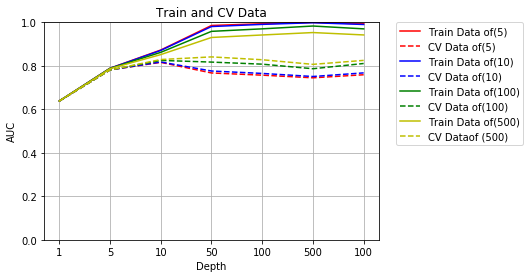

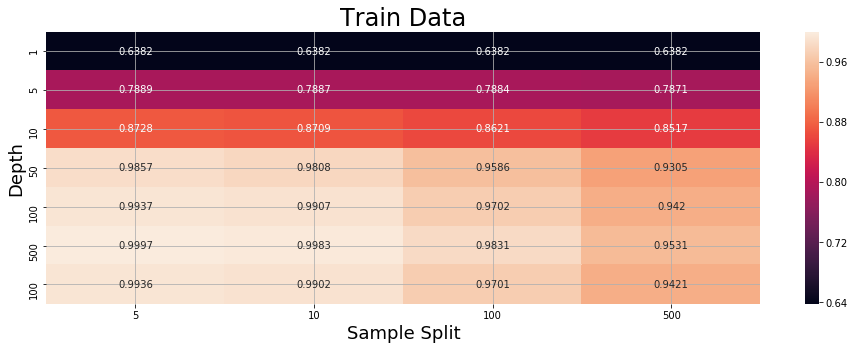

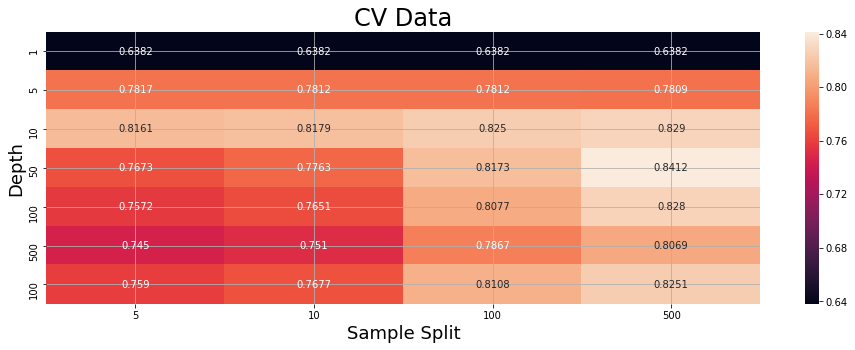

Optimal value of max_depth =  50  Optimal min_samples_split is : 500
--------------------------
Cv auc scores
[0.63822825 0.63822825 0.63822825 0.63822825 0.78165477 0.78118162
 0.7811762  0.78089648 0.81610346 0.81785086 0.82497895 0.82901288
 0.76730866 0.77625887 0.8172913  0.84116786 0.75715314 0.7651314
 0.80773959 0.82803354 0.74499855 0.75098662 0.7867425  0.80687326
 0.75899993 0.7676521  0.8108232  0.82513108]
Maximun Auc value : 0.841167862983478


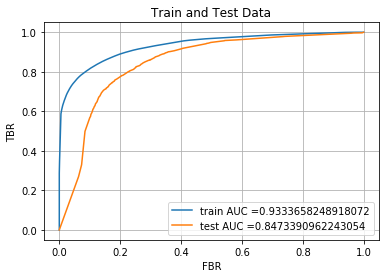

Train confusion matrix
[[ 6424   724]
 [ 6914 30828]]
Test confusion matrix
[[ 3964  1165]
 [ 5554 22317]]


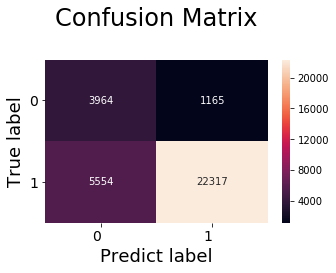

In [124]:
all_dt(X_train_bow,y_train,X_cv_bow)

### [5.1.1] Top 20 important features from<font color='red'> SET 1</font>

In [125]:
# Please write all the code with proper documentation
clf = DecisionTreeClassifier(max_depth= 50, min_samples_split=500,class_weight= 'balanced')
clf.fit(X_train_bow,y_train)
feat = vectorizer.get_feature_names()
n=20
coefs = sorted(zip(clf.feature_importances_, feat))
top = coefs[:-(n + 1):-1]

print("Feature importances\tFeatures")
for (coef1, feat1) in top:
    print("%.4f\t\t\t%-15s" % (coef1, feat1))


Feature importances	Features
0.1731			not            
0.1152			great          
0.0637			best           
0.0491			delicious      
0.0356			good           
0.0328			love           
0.0236			excellent      
0.0180			perfect        
0.0175			loves          
0.0175			bad            
0.0163			disappointed   
0.0159			favorite       
0.0135			not good       
0.0135			not great      
0.0122			tasty          
0.0094			wonderful      
0.0084			nice           
0.0076			amazing        
0.0073			terrible       
0.0068			awesome        


### [5.1.2] Graphviz visualization of Decision Tree on BOW,<font color='red'> SET 1</font>

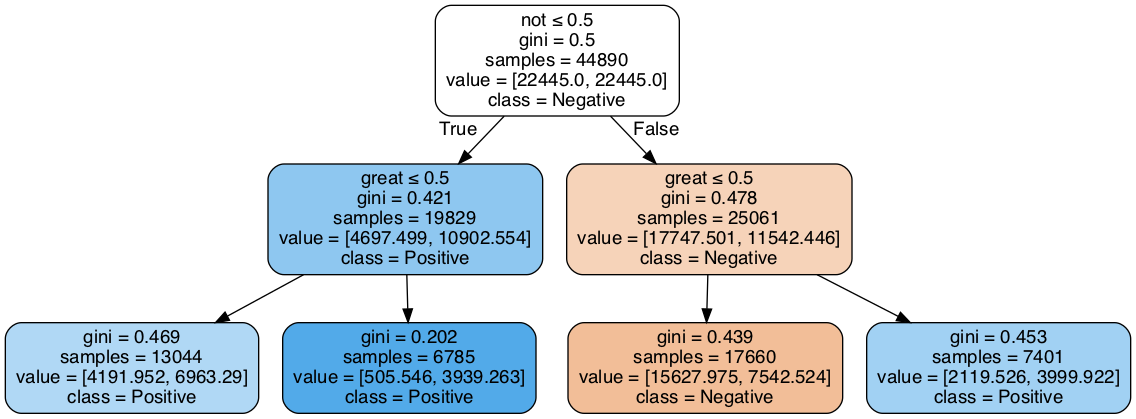

In [126]:
# Please write all the code with proper documentation
import pydot
clf = DecisionTreeClassifier(max_depth= 2, min_samples_split=500,class_weight= 'balanced')
clf.fit(X_train_bow,y_train)
names=vectorizer.get_feature_names()
dot_data = StringIO()  
tree.export_graphviz(clf, out_file=dot_data,feature_names=names, 
                     class_names=['Negative','Positive'],  
                     filled=True, rounded=True,  
                     special_characters=True)
graph = pydot.graph_from_dot_data(dot_data.getvalue())[0]
Image(graph.create_png())

## [5.2] Applying Decision Trees on TFIDF,<font color='red'> SET 2</font>

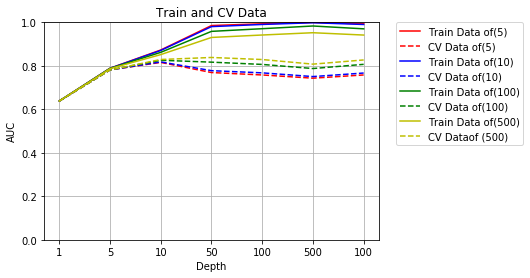

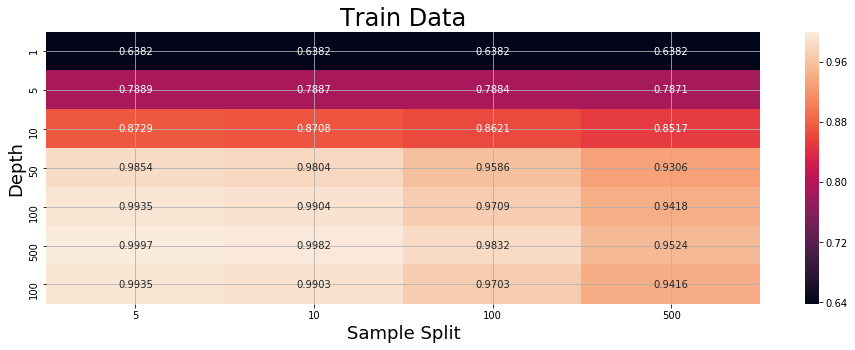

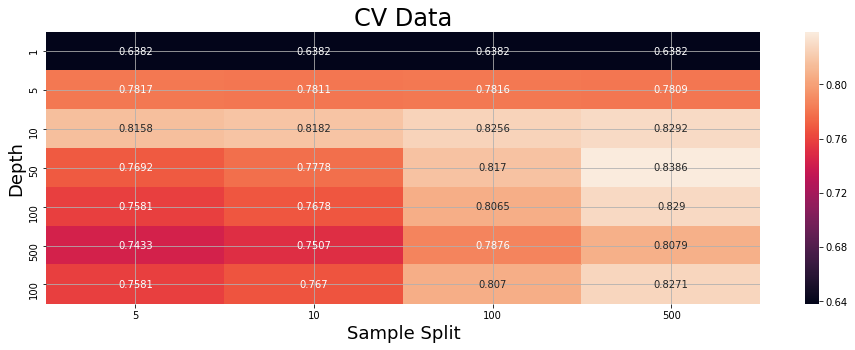

Optimal value of max_depth =  50  Optimal min_samples_split is : 500
--------------------------
Cv auc scores
[0.63822825 0.63822825 0.63822825 0.63822825 0.78170777 0.78107589
 0.78162128 0.78089648 0.81583388 0.81819682 0.8256137  0.82916547
 0.76923142 0.77782108 0.81700052 0.83855215 0.75807367 0.76777095
 0.80653847 0.82904648 0.74331187 0.7506596  0.78764356 0.807855
 0.75810284 0.76698066 0.80695758 0.82713734]
Maximun Auc value : 0.8385521546054655


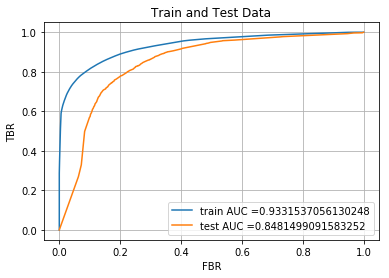

Train confusion matrix
[[ 6423   725]
 [ 6937 30805]]
Test confusion matrix
[[ 3976  1153]
 [ 5547 22324]]


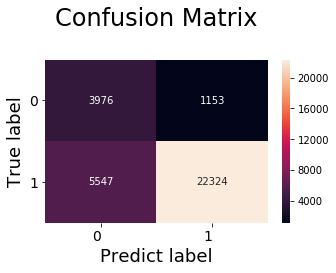

In [127]:
# Please write all the code with proper documentation
all_dt(X_train_tfidf,y_train,X_cv_tfidf)

### [5.2.1] Top 20 important features from<font color='red'> SET 2</font>

In [129]:
# Please write all the code with proper documentation

clf = DecisionTreeClassifier(max_depth= 50, min_samples_split=500,class_weight= 'balanced')
clf.fit(X_train_tfidf,y_train)
feat = tf_idf_vect.get_feature_names()
n=20
coefs = sorted(zip(clf.feature_importances_, feat))
top = coefs[:-(n + 1):-1]

print("Feature importances\tFeatures")
for (coef1, feat1) in top:
    print("%.4f\t\t\t%-15s" % (coef1, feat1))

Feature importances	Features
0.1965			not            
0.1256			great          
0.0680			best           
0.0546			delicious      
0.0437			love           
0.0421			good           
0.0251			disappointed   
0.0240			excellent      
0.0214			bad            
0.0213			perfect        
0.0178			favorite       
0.0176			loves          
0.0123			not good       
0.0119			wonderful      
0.0116			nice           
0.0115			easy           
0.0098			tasty          
0.0092			awesome        
0.0081			thought        
0.0076			works          


### [5.2.2] Graphviz visualization of Decision Tree on TFIDF,<font color='red'> SET 2</font>

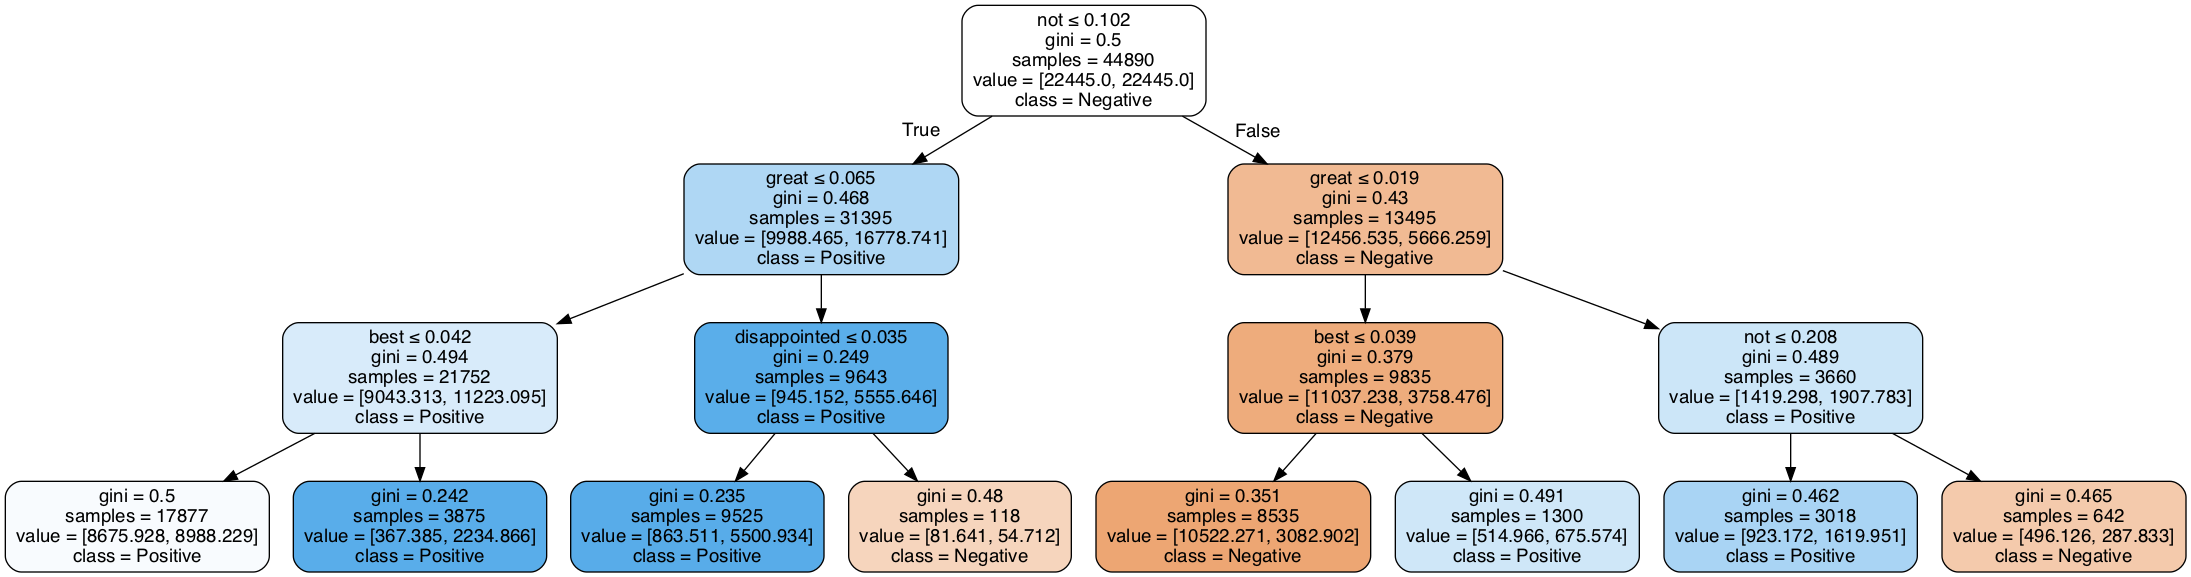

In [130]:
# Please write all the code with proper documentation
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=500)
tf_idf_vect.fit(X_train)
clf = DecisionTreeClassifier(max_depth= 3, min_samples_split=500,class_weight= 'balanced')
clf.fit(X_train_tfidf,y_train)
names=tf_idf_vect.get_feature_names()
dot_data = StringIO()  
tree.export_graphviz(clf, out_file=dot_data,feature_names=names, 
                     class_names=['Negative','Positive'],  
                     filled=True, rounded=True,  
                     special_characters=True)
graph = pydot.graph_from_dot_data(dot_data.getvalue())[0]
Image(graph.create_png())

## [5.3] Applying Decision Trees on AVG W2V,<font color='red'> SET 3</font>

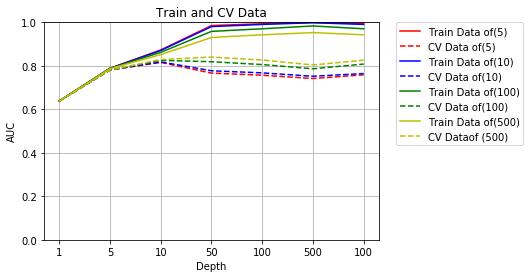

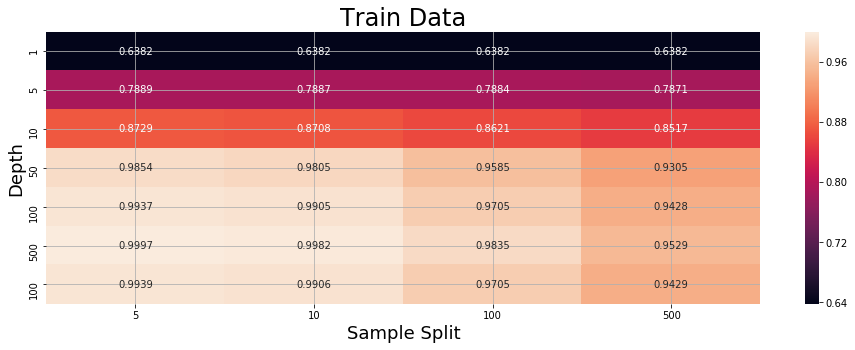

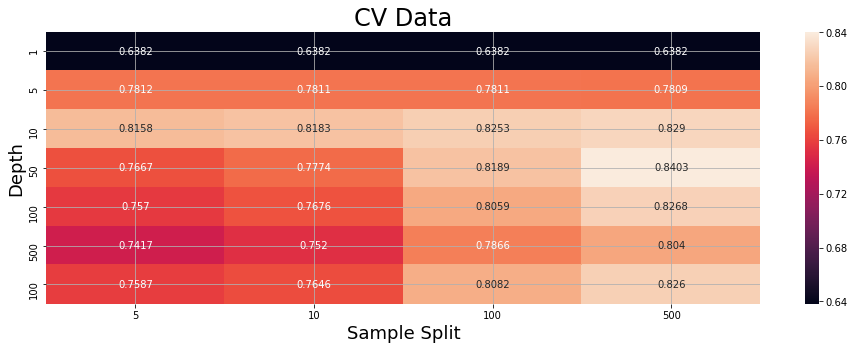

Optimal value of max_depth =  50  Optimal min_samples_split is : 500
--------------------------
Cv auc scores
[0.63822825 0.63822825 0.63822825 0.63822825 0.78123644 0.78112886
 0.78114979 0.78092291 0.81576077 0.81828738 0.82528986 0.82901148
 0.76671242 0.77737196 0.81888577 0.84031347 0.75698099 0.76758686
 0.80590132 0.82684164 0.74174984 0.75201366 0.78657485 0.80401669
 0.75866764 0.76460384 0.80821069 0.82604573]
Maximun Auc value : 0.8403134699713916


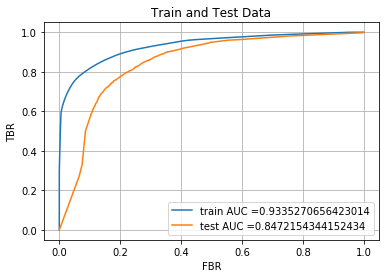

Train confusion matrix
[[ 6432   716]
 [ 6896 30846]]
Test confusion matrix
[[ 3970  1159]
 [ 5574 22297]]


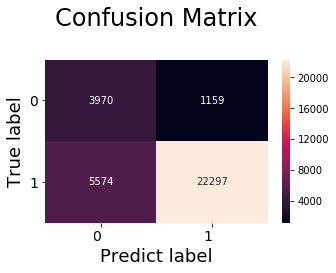

In [131]:
# Please write all the code with proper documentation
all_dt(train_vectors, y_train, X_cv)

## [5.4] Applying Decision Trees on TFIDF W2V,<font color='red'> SET 4</font>

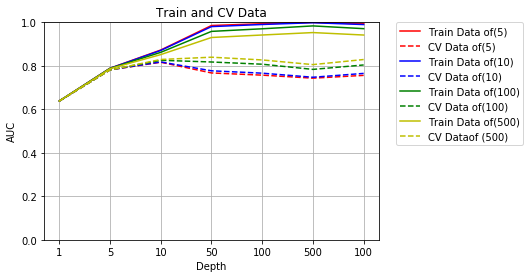

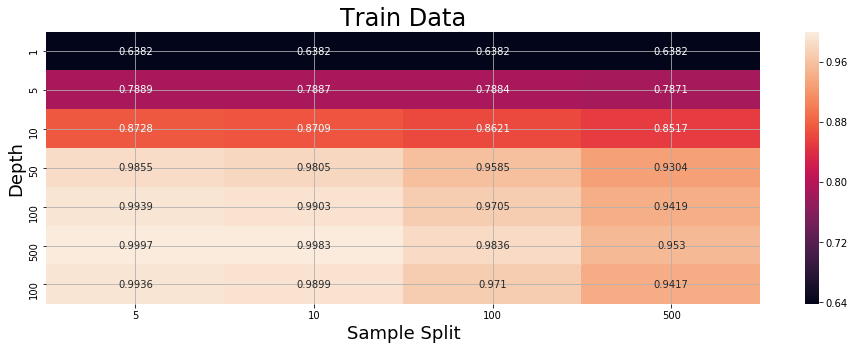

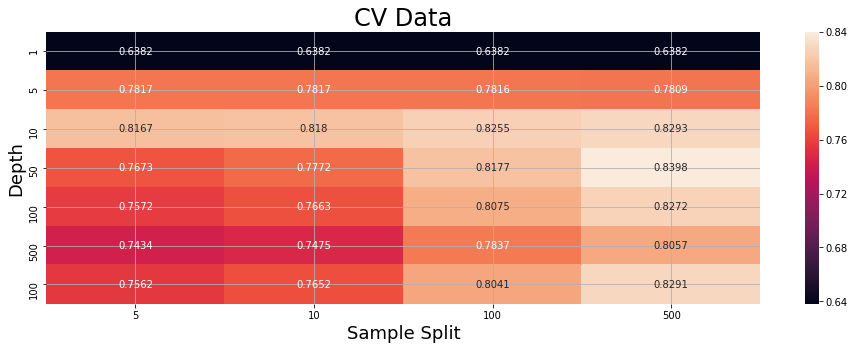

Optimal value of max_depth =  50  Optimal min_samples_split is : 500
--------------------------
Cv auc scores
[0.63822825 0.63822825 0.63822825 0.63822825 0.78165498 0.78165296
 0.78159487 0.78089648 0.81665358 0.81800719 0.82550669 0.82927569
 0.76734313 0.77720756 0.81772649 0.83975912 0.7572175  0.76630792
 0.80751379 0.82715567 0.74337999 0.74753721 0.78368366 0.80573015
 0.75618021 0.76524842 0.80408824 0.82906217]
Maximun Auc value : 0.8397591212163311


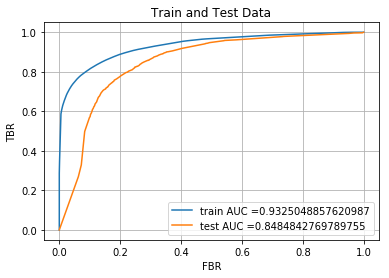

Train confusion matrix
[[ 6423   725]
 [ 6954 30788]]
Test confusion matrix
[[ 3974  1155]
 [ 5578 22293]]


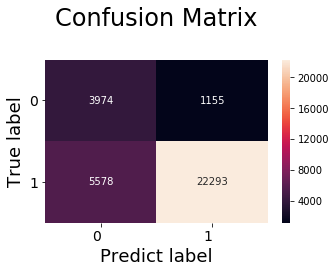

In [132]:
# Please write all the code with proper documentation
all_dt(tfidf_train_vectors,y_train,X_cv)

# [6] Conclusions

In [133]:
# Please compare all your models using Prettytable library

from prettytable import PrettyTable

 
Vectorizer = ['Bag of Words','TFIDF','AVG W2V','TFIDF W2V']

max_depth=[50, 50,50, 50]

sample_split =[500, 500,500, 500]

auc =[0.84,0.84,0.84,0.84]
 
numbering = [1,2,3,4]

# Initializing prettytable
ptable = PrettyTable()

# Adding columns
ptable.add_column("S.NO.",numbering) 
ptable.add_column("MODEL",Vectorizer)
 
ptable.add_column("Depth",max_depth)
ptable.add_column("Sample Split",sample_split)
ptable.add_column("AUC",auc)
 

print(ptable)

+-------+--------------+-------+--------------+------+
| S.NO. |    MODEL     | Depth | Sample Split | AUC  |
+-------+--------------+-------+--------------+------+
|   1   | Bag of Words |   50  |     500      | 0.84 |
|   2   |    TFIDF     |   50  |     500      | 0.84 |
|   3   |   AVG W2V    |   50  |     500      | 0.84 |
|   4   |  TFIDF W2V   |   50  |     500      | 0.84 |
+-------+--------------+-------+--------------+------+


### Conclussion 

1: Decision Tree is faster.

2: BOW, TFIDF and Avg W2v featurisation gave 84% AUC value.

3:Some other previous models we applied had better results than this.

4: The data points is 100K maybe if we would have more than that with other features it could give us better insight. 
